In [62]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt

# Read Data

In [7]:
def load_image(data_dir, label):
    # label is a boolean variable, means whether need to return labels
    labels = []
    pics = []
    for pic_name in os.listdir(data_dir):
        if label:
            # 注意，这里如果直接读，而不加int类型转换，会使得读出来的y是str类型
            labels.append(pic_name.split('_')[0])
        img = cv2.imread(data_dir+'/'+pic_name)
        pics.append(cv2.resize(img, (128, 128)))
    return np.array(pics), np.array(labels)

In [5]:
os.getcwd()

'E:\\个人\\study\\Machine-learning\\LiHongYi\\classification'

In [8]:
data_dir = '../../../DATA/hw3/food-11/'
train_dir = data_dir+'training'
val_dir = data_dir+'validation'
test_dir = data_dir + 'testing'

train_x, train_y = load_image(train_dir, True)
val_x, val_y = load_image(val_dir, True)
test_x, _ = load_image(test_dir, False)

print(len(train_x), len(val_x), len(test_x))

9866 3430 3347


(128, 128, 3)


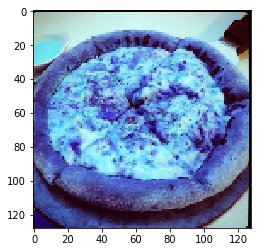

In [9]:
print(train_x[0].shape)
plt.imshow(train_x[1])

**此处显示为蓝色，是因为cv2读入图片为BGR格式，而plt为RGB格式，正好反了过来**

用索引[2, 1, 0]就可以正常显示成RGB颜色了。但颜色反了并不影响CNN的识别，所以作业模板里也没有改成2，1，0的格式。

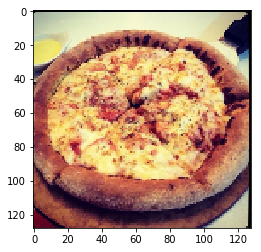

In [19]:
test_plt = train_x[1][:,:,[2,1,0]]
plt.imshow(test_plt)

# BASELINE

# DataSet

In [60]:
class ImgDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), self.y[idx]

train_dataset = ImgDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = ImgDataset(val_x, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Model

In [52]:
# baseline

# conv2d的参数[in_channels, out_channels, kernel_size(h,w), stride, padding]
# maxpool参数[kernel_size, stride, padding]
neural_network = nn.Sequential(
                    nn.Conv2d(3, 64, 3, 1, 1), # [64, 128, 128]
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2, 0),
    
                    nn.Conv2d(64, 128, 3, 1, 1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2, 0),
    
                    nn.Conv2d(128, 256, 3, 1, 1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2, 0),
    
                    nn.Conv2d(256, 512, 3, 1, 1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2, 0),
    
                    nn.Conv2d(512, 256, 3, 1, 1),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2, 0),
                    
                    #=====！！！===这个地方没做维度转换。
                    # 所以后面会报错，参考official的吧
                    # fc
                    nn.Linear(256*4*4, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Linear(512, 11)
                    )


In [61]:
import math
n_epochs = math.ceil(9866/4) #train_x/batch_size

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_network.parameters(), 
                             lr=0.001)

for epoch in range(30):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        print(data[0].shape)
        y_hat = neural_network(data[0])
        batch_loss = loss_func(y_hat, data[1])
        
        batch_loss.backward()
        optimizer.step()
        
        train_acc += np.sum(np.argmax(y_hat.data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            val_pred = neural_network(data[0])
            batch_loss = loss_func(val_pred, data[1])
            
            val_acc += np.sum(np.argmax(val_pred.data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
        
    

torch.Size([64, 3, 128, 128])


RuntimeError: size mismatch, m1: [65536 x 4], m2: [4096 x 1024] at C:\w\b\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:41

# official reference

## Read image

利用OpenCV (cv2) 读入照片并存放在numpy array中

In [73]:
import os
def readfile(path, label):
    # label是boolean variable，代表是否需要传回y值
    image_dir = sorted(os.listdir(path))
    # 这里制定好数据类型，后面就不会出错了
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img, (128, 128))
        if label:
            y[i] = int(file.split("_")[0])
    if label:
        return x, y
    else:
        return x

In [76]:
data_dir = '../../../DATA/hw3/food-11/'
print("reading data...")
train_x, train_y = readfile(os.path.join(data_dir, "training"), True)
val_x, val_y = readfile(os.path.join(data_dir, "validation"), True)
test_x = readfile(os.path.join(data_dir, "testing"), False)

print(len(train_x), len(val_x), len(test_x))

reading data...
9866 3430 3347


## Dataset

在pytorch中使用torch.utils.data的Dataset和DataLoader来包装data，让后续的training和testing更为方便。

Dataset需要overload两个函数：__len__ 和 __getitem__

其中len 必须回传dataset的大小，getitem则定义了当利用[]取值时，dataset应如何回传信息

事实上我们并不会直接使用到这两个函数，但使用DataLoader在enumerate Dataset时会使用到，没有实现的话会在程序运行阶段出现error

In [77]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(), #将图片转成tensor，并把数值normaliza到[0,1]
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            # label is required to be a longTensor
            # 转换成longTensor是因为交叉熵损失函数不能接受one hot形式，
            # 只能接受数组，之后交叉熵函数会自动转换为one-hot
            self.y = torch.LongTensor(y)
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X,Y
        else:
            return X

In [78]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

## Model

In [80]:
class Classifier(nn.Module):
    def __init__(self):
        #super继承父类
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input维度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),     # [64, 64, 64]
            
            nn.Conv2d(64, 128, 3, 1, 1),# [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      #[128, 32, 32]
            
            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]
            
            nn.Conv2d(256, 512, 3, 1, 1), #[512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Linear(512, 11)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## Training

使用training set训练，validation set寻找最好的参数

In [81]:
model = Classifier()
loss = nn.CrossEntropyLoss() # 是classification task，所以loss使用crossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer使用Adam
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    model.train() #确保model是在train model模式（开启dropout等...）
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用optimizer将model参数的gradient归零
        
        # 利用model得到预测的概率分布，实际上就是去呼叫model的forward函数
        train_pred = model(data[0]) # data[0]是x
        batch_loss = loss(train_pred, data[1]) # data[1]是y
        
        batch_loss.backward() # 利用backward算出每个参数的gradient
        optimizer.step() # 以optimizer用gradient进行更新参数值
        
        train_acc += np.sum(np.argmax(train_pred.data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
     
    model.eval() #将模型调为eval模式，固定梯度、bn等操作改变
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0])
            batch_loss = loss(val_pred, data[1])
            
            val_acc += np.sum(np.argmax(val_pred.data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
            
        #将结果print出来
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))   
    

[001/030] 2351.84 sec(s) Train Acc: 0.236975 Loss: 0.019641 | Val Acc: 0.250437 loss: 0.016705
[002/030] 2158.28 sec(s) Train Acc: 0.296169 Loss: 0.015507 | Val Acc: 0.244898 loss: 0.018152
[003/030] 2253.20 sec(s) Train Acc: 0.349584 Loss: 0.014609 | Val Acc: 0.336152 loss: 0.014706
[004/030] 2470.78 sec(s) Train Acc: 0.385769 Loss: 0.013735 | Val Acc: 0.351020 loss: 0.014559
[005/030] 2315.66 sec(s) Train Acc: 0.417900 Loss: 0.013139 | Val Acc: 0.376676 loss: 0.013652
[006/030] 2472.23 sec(s) Train Acc: 0.451652 Loss: 0.012345 | Val Acc: 0.165306 loss: 0.024146
[007/030] 2942.44 sec(s) Train Acc: 0.480235 Loss: 0.011734 | Val Acc: 0.174052 loss: 0.027017
[008/030] 2728.08 sec(s) Train Acc: 0.507095 Loss: 0.011173 | Val Acc: 0.491254 loss: 0.011588
[009/030] 2418.19 sec(s) Train Acc: 0.529495 Loss: 0.010648 | Val Acc: 0.477259 loss: 0.012521
[010/030] 2526.68 sec(s) Train Acc: 0.547436 Loss: 0.010218 | Val Acc: 0.460641 loss: 0.013093
[011/030] 2764.93 sec(s) Train Acc: 0.565173 Loss:

In [82]:
mmm = '111'
nnn = '222'
print(mmm, \
     nnn)

111 222
